In [1156]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import isnan

In [1157]:
conn = sqlite3.connect('data/attrition.db')
df = pd.read_sql_query('SELECT * FROM attrition', conn)
df

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time
0,1d172e75-2c13-4b73-a1da-18d442a10bf7,1,41,Female,5993,0.2 hours,Diploma,Engineering,2,Changi,Gold,7,1981,7
1,6dee0995-9ff1-44a6-b3f1-fc5f7270c8ab,0,49,Male,5130,0.7 hours,Diploma,Engineering,3,Thomson,Normal,11,1973,2
2,c9fff882-42e7-4e12-88ab-74aba95113dc,1,37,Male,2090,20.0 mins,Diploma,Medical,4,Thomson,Normal,1,1985,2
3,1521db93-82d8-46a8-9718-6acde2a7c001,0,33,Female,2909,20.0 mins,Master,Engineering,4,Thomson,Normal,9,1989,0
4,e8a69be8-c96a-4f37-b14c-b3c75aa32db3,0,27,Male,3468,0.3 hours,Diploma,Information Technology,1,Thomson,Normal,3,1995,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,853c0e3d-102d-4f0a-8eaf-77ab3ee6eb9e,0,55,Male,7168,0.4 hours,Master,Medical,3,Changi,Bronze,10,-1,5
2466,ffaa8f3e-845c-4609-86ba-c64162fd08be,1,28,Male,9138,53.61316468923773 mins,Diploma,Engineering,3,Changi,Normal,11,1994,3
2467,df9097af-60f5-4654-b479-75ce35ef2c9b,0,55,Male,11845,0.5 hours,Master,Engineering,3,Thomson,Normal,4,1967,5
2468,5675bfe3-c90a-47bb-b6c2-5d6e2005ef54,0,42,Female,12579,31.884495613579915 mins,Bachelor,Business,1,Changi,Silver,5,1980,2


Lets start by getting the shape of our dataset so we know what we are working with. 

In [1158]:
df.shape

(2470, 14)

We have 2470 datapoints and 14 columns. But one of the columns is what are are trying to predict (Attrition) so we have 13 features to analyse. Lets start by checking if there are any null values. 

In [1159]:
df.isna().sum()

Member Unique ID    0
Attrition           0
Age                 0
Gender              0
Monthly Income      0
Travel Time         0
Qualification       0
Work Domain         0
Usage Rate          0
Branch              0
Membership          0
Months              0
Birth Year          0
Usage Time          0
dtype: int64

There seems to be no missing datapoints which is great! Now lets take a look at each individual column and check that there are no incorrect entries or values that do not make sense. We will start by just getting a quick overview of the numerical data

In [1160]:
df.describe()

,Attrition,Age,Monthly Income,Usage Rate,Months,Birth Year,Usage Time
count,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000
mean,0.169636,35.970850,5143.199595,2.780972,10.634413,1734.040486,4.846964
std,0.375388,16.757217,6542.273046,1.033757,9.225734,655.077597,3.925911
min,0.000000,-1.000000,-24620.000000,1.000000,0.000000,-1.000000,0.000000
25%,0.000000,29.000000,2610.000000,2.000000,5.000000,1969.000000,2.000000
50%,0.000000,38.000000,4785.000000,3.000000,8.000000,1980.000000,4.000000
75%,0.000000,48.000000,7981.750000,4.000000,13.000000,1988.000000,6.000000
max,1.000000,69.000000,25326.000000,4.000000,57.000000,2004.000000,20.000000


There do seem to be a few issues that I can see just from this table. 
    1. There is a negative age. 
    2. There is a negative monthly income
    3. There is a negative birth year
Now lets take a look at each column individually

## Data Cleaning

We will ignore Member Unique ID as I do not think that a unique ID would in any way be useful to helping to predict attrition. 

#### Attrition

In [1161]:
df['Attrition'].unique()

array([1, 0])

Thankfully there are no issues with Attrition. If there were, that would be a major issue as this is the value we are predicting. 

#### Age

We know from earlier, that there are some negative values within this column. Lets take a closer look

In [1162]:
df['Age'][df['Age']<=0].count()

291

This seems to be a big issue. There are 291 data points with negative ages. This is more than 10% of our dataset. We cannot just delete 10% of our dataset. So we will have to consider either fixing these incorrect points or deleting the column all together. Lets take a closer look at what negative values there are for age. 

In [1163]:
df['Age'].loc[df['Age'] <= 0].unique()

array([-1])

So all the negative values are -1. We have incorrectly labelled datapoints. Lets take a look at the spread of the rest of the datapoints. We will take a look at a boxplot and a distribution plot.

<AxesSubplot: >

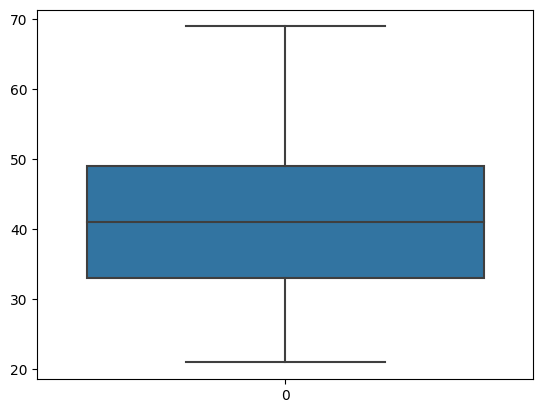

In [1164]:
sns.boxplot(df['Age'][df['Age']>=21])

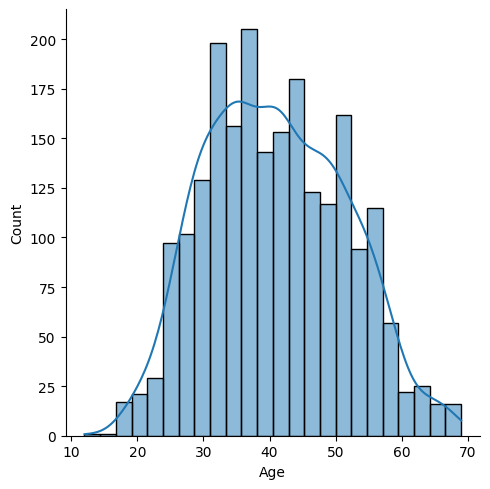

In [1165]:
sns.displot(df['Age'][df['Age']>0], kde = True)

The rest of the data (Age >=21) seems to be relatively non-skewed. Almost looks normally distributed. I think based on these plots, using the mean of the non-negative datapoints (rounded to the nearest whole number) would be an appropriate way to fill in the negative values. However, I have decided to go a different route which will be explained at a later section. 

#### Gender

Lets start by taking a look at the unique values within this feature

In [1166]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

We note that before we run any models using this feature, we will need to convert it. However, for the purposes of this eda, we will leave it as male/female. If we choose to use this feature, we will convert it using one-hot encoding. 

#### Monthly Income

Lets take a look at the monthly income feature. We know from above that there is at least one negative value within the feauture. 

In [1167]:
df['Monthly Income'][df['Monthly Income']< 0].count()

299

There are 299 negative values within this feature. Lets take a closer look at them. 

In [1168]:
np.sort(df['Monthly Income'][df['Monthly Income']< 0].unique())

array([-24620, -20704, -20703, -20218, -20115, -20114, -20054, -19999,
       -19926, -19818, -19665, -19658, -19537, -19094, -19049, -18990,
       -18947, -18722, -18606, -17266, -17261, -16892, -16823, -16659,
       -16559, -16328, -16200, -16109, -16064, -16034, -15992, -15306,
       -15168, -14484, -13940, -13826, -13402, -13320, -13120, -12936,
       -12896, -12735, -12328, -12323, -12276, -12207, -12161, -12111,
       -11890, -11713, -10880, -10851, -10820, -10800, -10725, -10673,
       -10609, -10496, -10467, -10453, -10377, -10333, -10231, -10159,
        -9991,  -9888,  -9852,  -9824,  -9724,  -9714,  -9439,  -9414,
        -9274,  -9256,  -8817,  -8755,  -8644,  -8607,  -8606,  -8599,
        -8542,  -8450,  -8398,  -8380,  -8350,  -8181,  -8146,  -8048,
        -8008,  -7980,  -7882,  -7779,  -7674,  -7654,  -7642,  -7560,
        -7553,  -7512,  -7327,  -7171,  -7005,  -6940,  -6885,  -6849,
        -6833,  -6815,  -6755,  -6737,  -6725,  -6635,  -6557,  -6496,
      

There are many different negative values. Lets take a look at the distribution of them. 

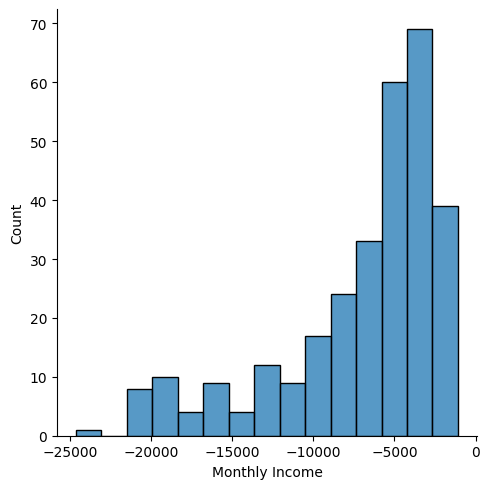

In [1169]:
sns.displot(df['Monthly Income'][df['Monthly Income']< 0])

So so the fact that its weighted towards the lower incomes as well as the fact that there are so many different unique negative values, is leading me to believe that a negative sign (-) was incorrectly added to these datapoints. I suspect that the distribution plot of the positive incomes will look like a reflection on the y axis of this histogram.  

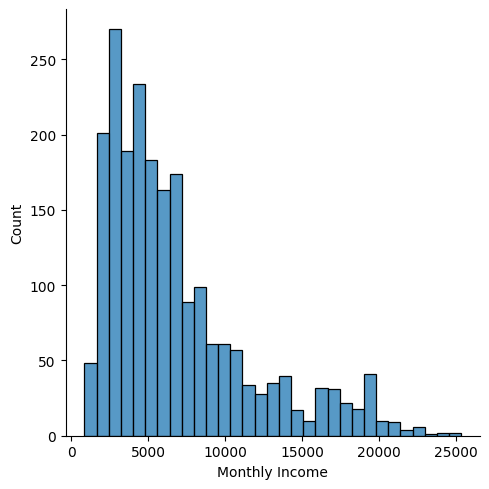

In [1170]:
sns.displot(df['Monthly Income'][df['Monthly Income']>0])

As suspected, it does. Therefore, I believe that the negative sign was added incorrectly. Will fix it by simply getting rid of the negative sign. 

In [1171]:
df['Monthly Income'] = df['Monthly Income'].abs()

#### Travel Time

Lets take a look at the travel time feature

In [1172]:
df['Travel Time'].unique()

array(['0.2 hours', '0.7 hours', '20.0 mins', '0.3 hours', '50.0 mins',
       '0.8 hours', '40.0 mins', '30.0 mins', '0.5 hours', '10.0 mins',
       '22.152170491849265 mins', '0.9 hours', '42.27732027062228 mins',
       '0.1 hours', '0.4 hours', '32.56739255726553 mins',
       '53.0473542956937 mins', '19.815236022824735 mins',
       '52.205729235648725 mins', '22.49412777253371 mins',
       '41.12707947908584 mins', '31.401497196062657 mins',
       '53.37674112017733 mins', '50.60372068235221 mins',
       '11.56004318189624 mins', '15.116187429153692 mins',
       '49.445802785304686 mins', '31.72861394229167 mins',
       '22.31098873338772 mins', '53.18722436287888 mins',
       '19.102285459123923 mins', '23.03104712045909 mins',
       '23.892979061709347 mins', '51.64755091792997 mins',
       '53.303308014961566 mins', '41.86978196397573 mins',
       '22.04441072020257 mins', '21.07218069435354 mins',
       '50.80163006842338 mins', '20.599094553649145 mins',
       '

So we see 2 things we need to think about here. Firstly, the data is recorded with 2 types. 
    1. mins
    2. hours
Secondly, the data is all recorded as strings. Lets deal with these issues. 

First lets check that hours and mins are the only 2 time measurements used.

In [1173]:
def checkTimeMeasurement(travelTime : str):
    return travelTime[-5:]
df.apply(lambda x: checkTimeMeasurement(x['Travel Time']), axis = 1).unique()

array(['hours', ' mins'], dtype=object)

So we now know, that there are only 2 ways that the time taken to arrive at the country club is recorded. Lets now convert everything to minutes so that its consistent across datapoints. The reason why minutes is chosen here, is just cause i prefer it. Additionally, I do not think that the decimal places are necessary for this column as when we have decimal points with minutes, it just means seconds. I do not think that the number of seconds more than a particular minute it takes to reach the country club would be relevant. 

In [1174]:
def convertTravelTimeToMinutes(travelTime : str):
    if travelTime[-5:] == 'hours':
        return int(np.round(float(travelTime[:-6])*60))
    else:
        return int(np.round(float(travelTime[:-6])))
df['Travel Time'] = df['Travel Time'].apply(convertTravelTimeToMinutes)

In [1175]:
df['Travel Time']

0       12
1       42
2       20
3       20
4       18
        ..
2465    24
2466    54
2467    30
2468    32
2469    22
Name: Travel Time, Length: 2470, dtype: int64

#### Qualification

In [1176]:
df['Qualification'].unique()

array(['Diploma', 'Master', 'Bachelor', 'Ph.D', "Bachelor's", "Master's",
       'Doctor of Philosophy'], dtype=object)

So we have several repeats of the same info but spelt slightly differently (some with apostrophe's, some without and different words to represent PhD). So lets fix that so that its all uniform. 

In [1177]:
def fixQualifications(qualifications: str):
    if qualifications == "Bachelor's":
        return 'Bachelor'
    if qualifications == "Master's":
        return 'Master'
    if qualifications == 'Doctor of Philosophy':
        return 'Ph.D'
    else: 
        return qualifications
df['Qualification'] = df['Qualification'].apply(fixQualifications)
df['Qualification'].unique()

array(['Diploma', 'Master', 'Bachelor', 'Ph.D'], dtype=object)

#### Work Domain

In [1178]:
df['Work Domain'].unique()

array(['Engineering', 'Medical', 'Information Technology', 'Business',
       'Science', 'Unemployed'], dtype=object)

There seem to be no issues with the Work Domain feature. 

#### Usage Rate

In [1179]:
df['Usage Rate'].unique()

array([2, 3, 4, 1])

No issues found with Usage Rate feature. 

#### Branch

In [1180]:
df['Branch'].unique()

array(['Changi', 'Thomson', 'Kranji'], dtype=object)

No issues found with Branch feature

#### Membership

In [1181]:
df['Membership'].unique()

array(['Gold', 'Normal', 'Bronze', 'Silver'], dtype=object)

No issues found. Although I am going to assume that the membership tiers go: Normal < Bronze < Silver < Gold. 

#### Months

In [1182]:
np.sort(df['Months'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 57])

No issues found with Months feature. 

#### Birth Year

In [1183]:
np.sort(df['Birth Year'].unique())

array([  -1, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004])

There is a negative value (-1) within the birth year feature. Lets take a closer look. 

In [1184]:
df['Birth Year'][df['Birth Year'] == -1].count()

308

There are 308 datapoints with negative values. We will deal with this in a later section together with the negative values of the Age feature. 

#### Usage Time

In [1185]:
np.sort(df['Usage Time'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

We note here that a usage time of 20 hours seems unrealistic as after a quick google, the country clubs in Singapore are open for at most 18 hours per day. We will assume that any datapoints with a usage time greater than that was a mistype and will just set any number greater than 18 to 18. 

In [1186]:
def changeUsageTime(usageTime: int):
    if usageTime > 18:
        return 18
    else:
        return usageTime
df['Usage Time'] = df['Usage Time'].apply(changeUsageTime)

In [1187]:
np.sort(df['Usage Time'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

#### Dealing with the negative values in Age and Birth Year feature

In this section, we will deal with the negative values found in the Age and Birth Year feature. This is because, theoretically, Age + Months = Actual Age of Client, where actual age of Client is calculated by taking the difference between Birth Year and 2022. Lets first consider whether its possible to fill all negative values using this method by first checking if there are any negative values in the same row for both features. 

For simplicity, we will change all negative values to NaaN as they are essentially the same thing i.e negative = missing

In [1188]:
df['Age'] = df['Age'].mask(df['Age']<0)
df['Birth Year'] = df['Birth Year'].mask(df['Birth Year']<0)
df[(df['Age'].isna())&(df['Birth Year'].isna())]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time


There are no datapoints where both Birth Year and Age are missing. We do not need to check the Months feature as we know from above, that no datapoints are missing. 

Lets now check and see if our idea abot Age + Months = Actual Age of the Member is a good way to fill in the missing values. We will first create a new column called 'Client Age' to get the actual age of the member calculated from their birth year. We will then check the difference between Age + Months and the Actual Age of the member.  

In [1189]:
df['Birth Year'] = df['Birth Year'].mask(df['Birth Year'] < 0)
df['Age'] = df['Age'].mask(df['Age'] < 0)
def convertYearToAge(birth_year :int):
    return 2022 - birth_year
df['Client Age'] = df['Birth Year'].apply(convertYearToAge)

In [1190]:
def checkAssumption(age_joining :float, age_current: float, num_months: float):
    return (age_joining + (num_months)/12) - age_current
df['Check Assumption'] = df.apply(lambda x: checkAssumption(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Check Assumption'].describe()

count    1871.000000
mean        0.881881
std         0.764586
min         0.000000
25%         0.416667
50%         0.666667
75%         1.000000
max         4.416667
Name: Check Assumption, dtype: float64

That is interesting. So there are situations where our theory is off by more than 4 years. Lets take a look at some of these datapoints. 

In [1191]:
df[df['Check Assumption'] > 2]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption
18,7dc2b0af-0f59-47b8-990f-2f19b6c13db6,0,53.0,Female,15427,20,Master,Engineering,1,Changi,Normal,26,1969.0,6,53.0,2.166667
98,b76eb2fc-710c-425f-9960-116d86db0b96,0,58.0,Male,13872,42,Master,Information Technology,4,Changi,Bronze,38,1964.0,1,58.0,3.166667
119,bca4f43a-80ec-4092-b2ac-b69da2a4477f,0,43.0,Male,16959,48,Diploma,Engineering,3,Changi,Silver,26,1979.0,7,43.0,2.166667
126,22eca069-e2ac-46ab-9c0c-11fd33bfb919,1,58.0,Female,10312,50,Master,Information Technology,4,Thomson,Bronze,41,1964.0,4,58.0,3.416667
178,b2618709-894f-49a1-a7f6-f2c74269147d,0,46.0,Female,10453,12,Diploma,Business,2,Changi,Normal,25,1976.0,4,46.0,2.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,3015e480-9d4f-4d7e-967a-f67306ae01d0,0,44.0,Male,14942,53,Bachelor,Engineering,3,Thomson,Normal,44,1978.0,5,44.0,3.666667
2405,bee68458-2c14-4a1d-b4e9-b39f077ea60c,0,43.0,Female,7242,24,Diploma,Information Technology,4,Thomson,Gold,27,1979.0,3,43.0,2.250000
2419,a8a786bc-ee9b-4bc8-b3f8-c1e2daf3b61a,0,47.0,Male,6505,23,Ph.D,Information Technology,2,Changi,Normal,50,1975.0,6,47.0,4.166667
2428,fcd95a4c-1a75-4488-8d75-69c264345230,0,44.0,Female,1133,31,Ph.D,Information Technology,3,Thomson,Normal,43,1978.0,3,44.0,3.583333


This is interesting. So it seems that there might be some mistakes made in the datapoints for either Age, Months and/or Birth Year. We will have to investigate this in the next section. However, first we will deal with the missing values for the Age and Birth Year features. 

We note that when using the equation above (Age + Months = Client Age), we were at most off by 4.4167 years with the mean being 0.88. Based on this, I conclude that using this method to fill in the missing values is likely to result in a Age and Birth Year closer to the true value than using a central tendancy method such as just filling missing values using mean/median. Therefore, we will fill in missing values using the equation above. 

In [1192]:
def fillInMissingAgeValues(join_age: float, current_age:float, months_member: int):
    if isnan(join_age):
        return np.round(current_age - (months_member/12))
    else:
        return join_age
df['Age'] = df.apply(lambda x: fillInMissingAgeValues(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Age'].isna().value_counts()

False    2470
Name: Age, dtype: int64

In [1193]:
def fillInMissingBirthYearValues(join_age:float, birth_year: int, months_member:int):
    if isnan(birth_year):
        return 2022 - np.round(join_age + (months_member/12))
    else:
        return birth_year
df['Birth Year'] = df.apply(lambda x: fillInMissingBirthYearValues(x['Age'], x['Birth Year'], x['Months']), axis = 1)
df['Client Age'] = df['Birth Year'].apply(convertYearToAge) #to fill in all the previously NaN values in Client Age
print(df['Client Age'].isna().value_counts())
df['Birth Year'].isna().value_counts()

False    2470
Name: Client Age, dtype: int64


False    2470
Name: Birth Year, dtype: int64

#### Possible mistakes made with Age, Months or Birth Year features

After examining some rows, I have realised that there is likely to be some errors in the recording of the Age/Months/Birth Year features based on my understanding of them. Lets take a look at some examples:

In [1194]:
df[['Age', 'Months', 'Birth Year', 'Client Age']][df['Check Assumption'] > 2]

,Age,Months,Birth Year,Client Age
18,53.0,26,1969.0,53.0
98,58.0,38,1964.0,58.0
119,43.0,26,1979.0,43.0
126,58.0,41,1964.0,58.0
178,46.0,25,1976.0,46.0
...,...,...,...,...
2391,44.0,44,1978.0,44.0
2405,43.0,27,1979.0,43.0
2419,47.0,50,1975.0,47.0
2428,44.0,43,1978.0,44.0


If we take a look at the first row (index 18), here we have a member that signed up as a member at age 53, has already been a member for 26 months (2 years and 2 months) and has a birth year of 1969 which implies the client is 53 years old this year(2022). All 3 features in this row cannot be true at the same time. Therefore, an incorrect entry was made in at least one of these feature entries. 

In my opinion, the most likely feature to be incorrect is Age as Birth Year would have been taken from the Member's identification provided when signing up for membership and Months would have just been gotten directly from the Country Club's system. Therefore, I will assume that in cases such as above, the features Birth Year and Months are correct and adjust the Age feature accordingly so all the numbers tally. 

To simplify the process, I am going to assume that all member's birthdays have already passed so when we do calculated their current age (Client Age feature) it is accurate. I am going to change adjust the Ages feature where the Check Assumption feature created which calculates the difference between (Age + Months) and Client Age is greater than or equal to 1. This is because, in those situations we can be 100% sure that there is an error as the numbers do not add up. 

In [1195]:
def correctAges(check_assumption : float, current_age: float, member_months: int, join_age: float):
    if check_assumption >= 1:
        return np.round(current_age - (member_months/12))
    else:
        return join_age

In [1196]:
df['Age'] = df.apply(lambda x: correctAges(x['Check Assumption'], x['Client Age'], x['Months'], x['Age']), axis = 1)
df['Check Assumption'] = df.apply(lambda x: checkAssumption(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Check Assumption'][(df['Check Assumption'] >=1) | (df['Check Assumption'] <=-1)].count() 

0

Lets now take a look at the distribution of Age after our changes and make sure there are no issues. 

In [1197]:
df['Age'].describe()

count    2470.000000
mean       40.331984
std        10.360449
min        12.000000
25%        32.000000
50%        40.000000
75%        48.000000
max        69.000000
Name: Age, dtype: float64

This is interesting. The youngest member joined at the age of 12. This seems a bit young to be a member of a country club. 

After a quick google, the youngest age that a person could be a member of a country club is 18 years old. Lets take a look at all the members who joined at under the age of 18.

In [1198]:
df[df['Age'] < 18]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption
1833,978342bd-10ce-4c9a-b243-dd23701b5a20,0,12.0,Female,10058,12,Master,Engineering,2,Thomson,Normal,14,2009.0,5,13.0,0.166667
1992,21a01ceb-82e4-46ae-b4cd-942ea393c456,0,17.0,Male,4012,13,Diploma,Business,1,Thomson,Normal,10,2004.0,14,18.0,-0.166667
2215,d47a3d50-ca65-4765-9508-3352a7b437c4,0,15.0,Female,3920,42,Master,Business,2,Thomson,Normal,7,2006.0,2,16.0,-0.416667


So it seems that this country club has a lot of extremely smart youngsters. With them having a 12 year old female with a Masters degree and earning $10000 per month, a 15 year old female with a Master's degree. I am going to treat the 2 female members as corurpt data and just delete them. This is because, the age, income and qualification do not sense. 

As for the 17 year old male member, I think considering the Birth Year is 2004, and the Months is only 10, I will just assume that the Age was incorrectly entered and change it to 18 (the minimum age to be a member).

In [1199]:
df.drop(index = [1833, 2215], inplace=True)
df.at[1992, 'Age'] = 18.0
df[df['Age'] < 18]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption


Before we start on the univariate analysis of each feature, we will drop the created column Check Assumption and we will also drop the provided feature Birth Year as all the information is already in Client Age and Client Age is a much more useful form of it. We will also drop the Member Unique ID feature as I do not think it is useful for helping to predict attrition. 

In [1200]:
df.drop('Check Assumption', inplace=True, axis = 1)
df.drop('Birth Year', inplace=True, axis=1)
df.drop('Member Unique ID', inplace=True, axis = 1)

Now that we have finished with the data cleaning we can move onto the univariate analysis. 

### Univariate Analysis

Lets start by restating all the various features:

In [1201]:
df.columns

Index(['Attrition', 'Age', 'Gender', 'Monthly Income', 'Travel Time',
       'Qualification', 'Work Domain', 'Usage Rate', 'Branch', 'Membership',
       'Months', 'Usage Time', 'Client Age'],
      dtype='object')

#### Attrition

([<matplotlib.patches.Wedge at 0x13f1259a0>,
 [Text(-0.9472151304674981, 0.5592705039723095, 'No'),
  Text(0.9472151304674982, -0.5592705039723092, 'Yes')],
 [Text(-0.5166627984368171, 0.3050566385303506, '83.0%'),
  Text(0.5166627984368171, -0.3050566385303504, '17.0%')])

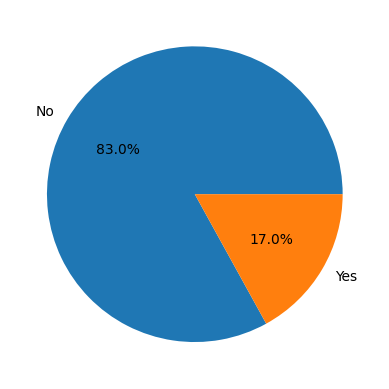

In [1216]:
plt.pie(df['Attrition'].value_counts()[[0,1]], autopct='%1.1f%%', labels=['No', 'Yes'])


The majority of the Members of this dataset Stayed (No) at 83% and only 17% of the Members from this dataset left (Yes) the country club. After seeing these percentages, I can understand why the country club would be concerned about Member Attrition. Losing 17% of your memberbase is a lot. 

#### Age

In [1202]:
df['Age'].describe()

count    2468.000000
mean       40.354133
std        10.335446
min        18.000000
25%        32.000000
50%        40.000000
75%        48.000000
max        69.000000
Name: Age, dtype: float64

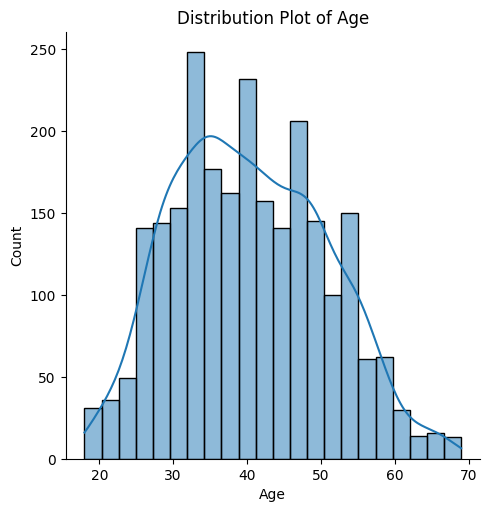

In [1203]:
sns.displot(df['Age'], kde=True).set(title = 'Distribution Plot of Age')

This feature seems to be approximately normally distributed with a slight positive skew. We can also see that the majority of datapoints fall within the 35-37.5 bucket. 

[Text(0.5, 1.0, 'BoxPlot of Age')]

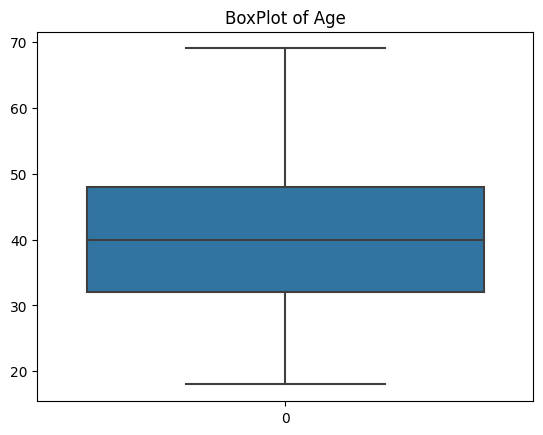

In [1204]:
sns.boxplot(df['Age']).set(title='BoxPlot of Age')

Again we can see the good distribution of this feature with it having no outliers.

In [1205]:
df['Attrition'].value_counts()

0    2049
1     419
Name: Attrition, dtype: int64

Lets see if we can see any obvious relationships between the Age and Attrition columns. 

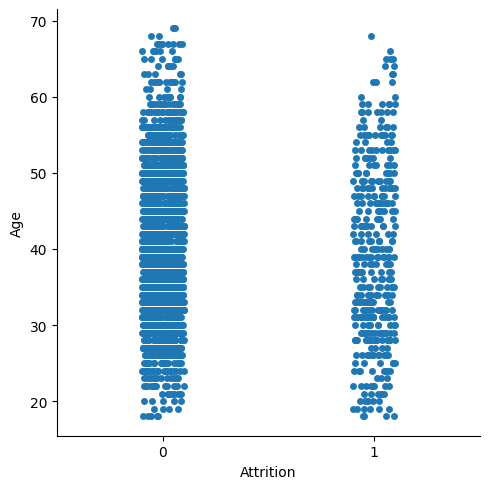

In [1224]:
sns.catplot(data = df, x = "Attrition", y = 'Age')

We can see that it seems that there doesn't seem to be any obvious indication that certain joining age groups stay/leave more. We note that the increased density of the 0 Attrition is mainly due to the fact that over 83% of our datapoints have Attrition = 0. 

#### Gender

In [1222]:
sns.barplot(df['Gender'])

ValueError: could not convert string to float: 'Female'

([<matplotlib.patches.Wedge at 0x13cf06910>,
 [Text(-0.3105159685893225, 1.0552629213854883, 'Male'),
  Text(0.3105159685893226, -1.055262921385488, 'Female')],
 [Text(-0.16937234650326682, 0.5755979571193571, '59.1%'),
  Text(0.16937234650326685, -0.5755979571193571, '40.9%')])

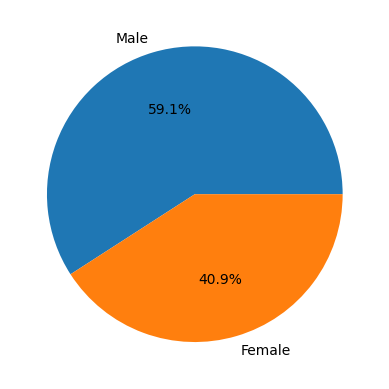

In [780]:
plt.pie(df['Gender'].value_counts(), autopct='%1.1f%%', labels=['Male', 'Female'])


So 59.1% of the members of this dataset are Male and 40.9% are female. Lets see if there exists any obvious relationship between the Gender of the member and the Attrition. 

Text(0.5, 1.0, 'Female')

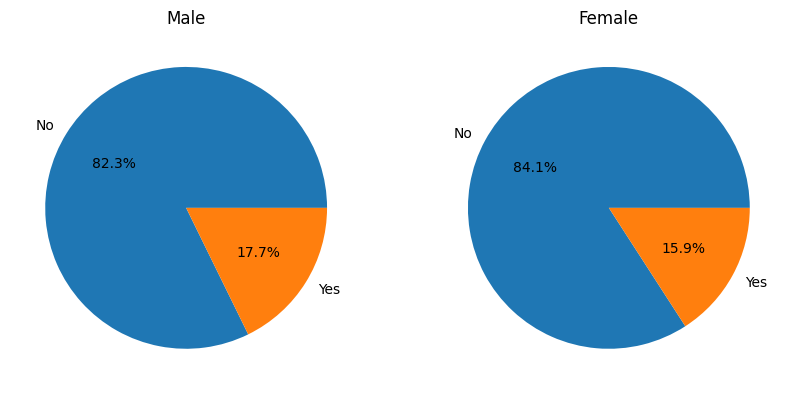

In [1210]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (10,5))
fig.add_subplot(1,2,1)
pie_jan = plt.pie(df[df['Gender'] == 'Male']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Male')
fig.add_subplot(1,2,2)
pie_jan = plt.pie(df[df['Gender'] == 'Female']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Female')

The distribution of members staying (No) and leaving (Yes) does not seem to differ much between the different Genders with 17.7% of the Male Members leaving and 15.9% of the Female Members. Not too big a difference. 

#### Monthly Income

In [1218]:
df['Monthly Income'].describe()

count     2468.000000
mean      6837.211912
std       4744.160002
min        854.000000
25%       3347.500000
50%       5393.000000
75%       8608.250000
max      25326.000000
Name: Monthly Income, dtype: float64

As we would expect with income, there is a large difference between the 75th Percentile (8608.25) and the max (25326). This is expected as the majority of people would earn within a particular range with very few outside that range on both sides. 

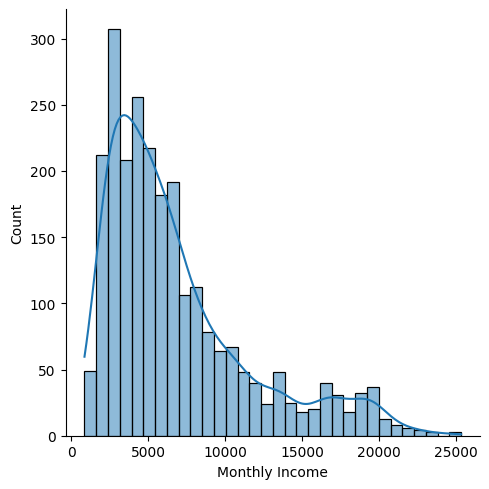

In [1219]:
sns.displot(df['Monthly Income'], kde=True)

As expected, the monthly income distribution plot is extremely positively skewed. Although we have a slight jump in the members earning between 15000-20000 per month. 

<AxesSubplot: >

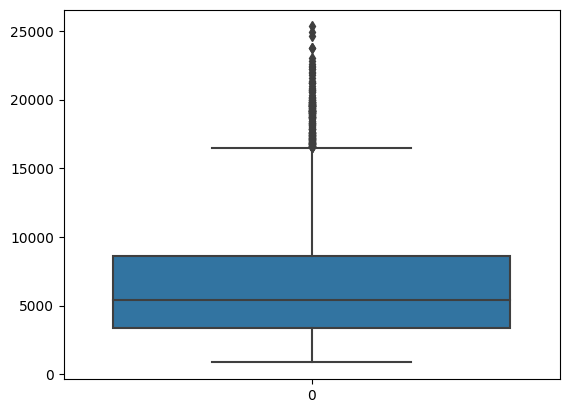

In [1220]:
sns.boxplot(df['Monthly Income'])

As expected from the distribution plot being so positively skewed, the boxplot also shows a lot of outliers above the upper whisker. However, this is expected as we saw from the distribution plot. 

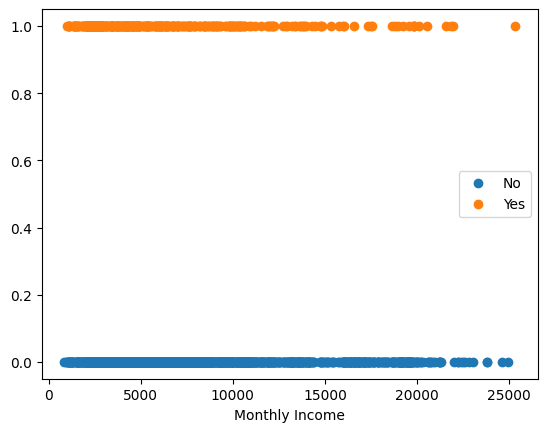

In [1221]:
plt.plot(df['Monthly Income'][df['Attrition'] == 0], np.zeros_like(df['Age'][df['Attrition'] == 0]), 'o')
plt.plot(df['Monthly Income'][df['Attrition'] == 1], np.ones_like(df['Age'][df['Attrition'] == 1]), 'o')
plt.xlabel('Monthly Income')
plt.gca().legend(('No', 'Yes'))
plt.show()